# Importing the relevant libraries

In [68]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
sns.set()

# Data Preprocessing

### Importing the Database

In [70]:
df = pd.read_csv('ml_datasource.csv')
df.head()

student_country  days_on_platform  minutes_watched  courses_started  \
0              US               288            358.1                1   
1              SG               260              1.7                1   
2              TR               260             22.4                1   
3              KE               259             18.8                1   
4              IN               259            118.0                2   

   practice_exams_started  practice_exams_passed  minutes_spent_on_exams  \
0                       2                      2                   15.81   
1                       1                      0                   16.00   
2                       1                      0                    0.93   
3                       1                      1                   14.63   
4                       2                      1                   16.48   

   purchased  
0          0  
1          0  
2          0  
3          0  
4          0

In [72]:
df.columns

Index(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started', 'practice_exams_passed',
       'minutes_spent_on_exams', 'purchased'],
      dtype='object')

In [74]:
#let's see how many students from Azerbaijan :)
df[df.student_country == 'AZ'].shape[0]

111

In [76]:
#let's see how many students from Korea :)
df[df.student_country == 'KR'].shape[0]

41

In [78]:
#To avoid accidentally modifying the original data source, we copy the raw data in a new variable
data = df.copy()

In [80]:
data.shape

(17761, 8)

### Removing Outliers

In [83]:
df.head()

student_country  days_on_platform  minutes_watched  courses_started  \
0              US               288            358.1                1   
1              SG               260              1.7                1   
2              TR               260             22.4                1   
3              KE               259             18.8                1   
4              IN               259            118.0                2   

   practice_exams_started  practice_exams_passed  minutes_spent_on_exams  \
0                       2                      2                   15.81   
1                       1                      0                   16.00   
2                       1                      0                    0.93   
3                       1                      1                   14.63   
4                       2                      1                   16.48   

   purchased  
0          0  
1          0  
2          0  
3          0  
4          0

In [85]:
df_numeric = df.select_dtypes(['number']) # select only numeric columns

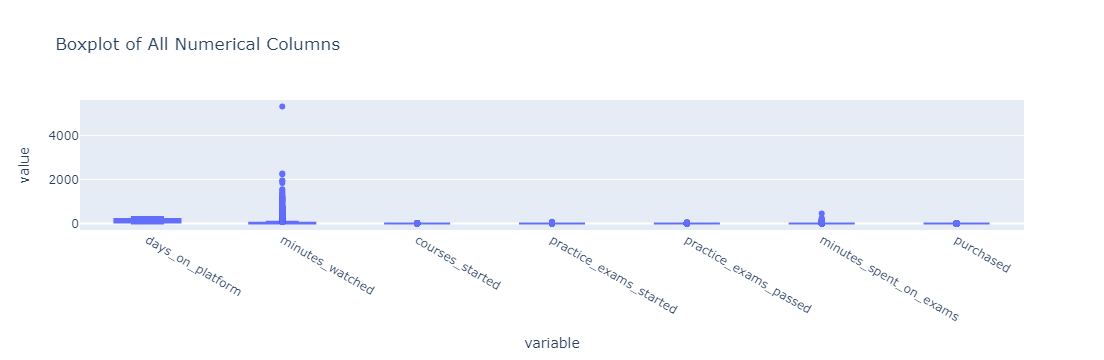

In [89]:
px.box(df_numeric, 
             points="outliers",  # by default outliers
             title="Boxplot of All Numerical Columns")

### Distibution plot of numeric columns

<Axes: xlabel='practice_exams_passed', ylabel='Density'>

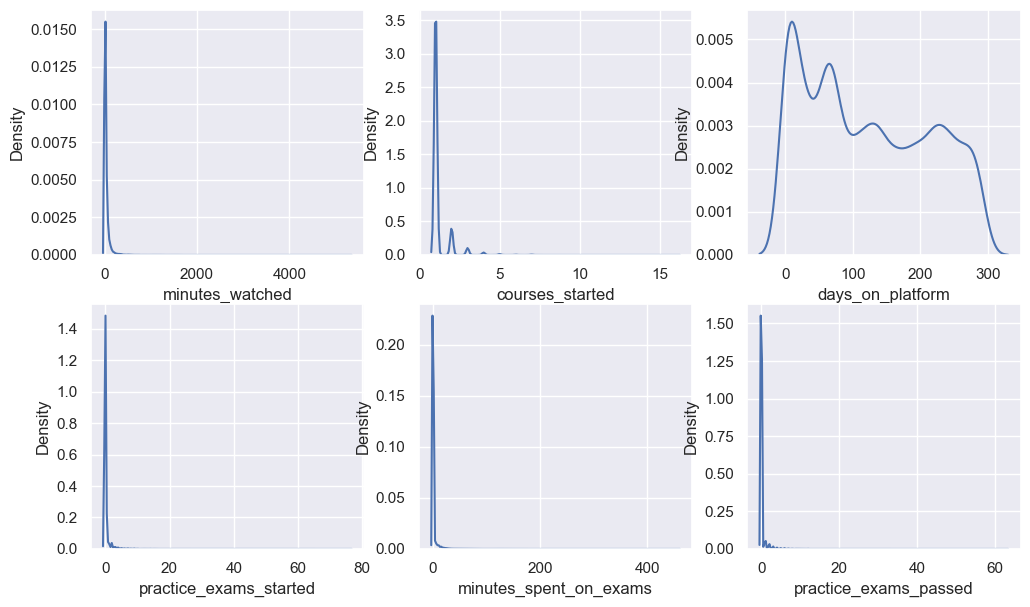

In [92]:
fig, axes = plt.subplots(2,3, figsize = (12,7))
sns.kdeplot(df.minutes_watched,ax = axes[0,0])
sns.kdeplot(df.courses_started,ax = axes[0,1])
sns.kdeplot(df.practice_exams_started,ax = axes[1,0])
sns.kdeplot(df.minutes_spent_on_exams,ax = axes[1,1])
sns.kdeplot(df.days_on_platform,ax = axes[0,2])
sns.kdeplot(df.practice_exams_passed,ax = axes[1,2])

In [93]:
#Remove the minutes watched larger than 1,000
df = df[df.minutes_watched<1000]

In [94]:
# Remove the number of courses surpassing 10
df = df[df.courses_started<10]

In [95]:
# Remove number of practice exams started higher than 10
df = df[df.practice_exams_started <10]

In [96]:
# Remove the minutes go beyond 40 mins
df = df[df.minutes_spent_on_exams < 40]

### Checking for Multicollinearity

In [103]:
#we should go through numeric columns only in order to calculate VIF values of columns
def calculate_vif_values(df):
    df2 = df.select_dtypes(['number']).iloc[:,:-1] #we should choose all numeric values and exclude target variable at the same time
    df_new = pd.DataFrame()
    df_new['col_names'] = df2.columns
    df_new['vif_values'] = [variance_inflation_factor(df2.values,x) for x in range(df2.shape[1])]
    return df_new

In [105]:
calculate_vif_values(df)
#there are only 2 columns with the VIF value more than 5

col_names  vif_values
0        days_on_platform    2.304024
1         minutes_watched    1.787986
2         courses_started    3.183620
3  practice_exams_started   10.497136
4   practice_exams_passed    8.030920
5  minutes_spent_on_exams    3.321170

In [107]:
#Let's remove the column with highest VIF
df = df.drop(columns ='practice_exams_started')

In [109]:
#now let's inspect VIF values of the remaining columns  
calculate_vif_values(df)

col_names  vif_values
0        days_on_platform    2.302045
1         minutes_watched    1.787632
2         courses_started    3.176553
3   practice_exams_passed    2.551049
4  minutes_spent_on_exams    2.583044

VIF values of the columns are now less than 0

### Dealing with NaN Values

In [113]:
df.isnull().sum()

student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [115]:
df[df['student_country'].isna()]

student_country  days_on_platform  minutes_watched  courses_started  \
311               NaN                88             58.1                1   
337               NaN                86             43.0                1   
556               NaN               121            241.9                2   
806               NaN                64             86.4                1   
1097              NaN                72             67.5                1   
12363             NaN                84              6.2                1   
12633             NaN                78              3.0                1   
16946             NaN                11              8.2                1   

       practice_exams_passed  minutes_spent_on_exams  purchased  
311                        2                   11.20          1  
337                        2                   12.96          0  
556                        3                   21.29          0  
806                        2                    4.98          0  
1097                       1                    6.27          0  
12363                      0                    0.00          0  
12633                      0                    0.00          0  
16946                      0                    0.00          0

In [117]:
#it truns out that all missing values in the student country column are actually the country "Namibia". Let's replace the values with "NAM".
df['student_country'] = df['student_country'].fillna('NAM')

### Splitting the Data

In [120]:
X = df.drop(columns = 'purchased')
y = df['purchased']

In [122]:
y.value_counts()

purchased
0    15991
1     1623
Name: count, dtype: int64

target data is highly imbalanced

In [125]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 365,stratify = y)
#applied stratify=y , because our target data is highly imbalanced

In [127]:
df.student_country.nunique()

172

### Encoding the Data

In [130]:
encoder = OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value=170)

In [132]:
#creating new column for student_country wiht encoded values
X_train['student_country_enc'] = encoder.fit_transform(X_train[['student_country']])
X_test['student_country_enc'] = encoder.transform(X_test[['student_country']])

In [134]:
X_train['student_country_enc'].max()

167.0

The encoder doesn't know how to transform values from the test data that hasn't previously seen in train data. Maximum value for encoded column is 167. Thta is unknown value is assigned to 170

In [137]:
#droping original column
X_train.drop(columns = 'student_country',inplace = True)
X_test.drop(columns = 'student_country', inplace = True)

# Creating a Logistic Regression Model

In [232]:
import statsmodels.api as sm

In [234]:
# in statsmodels we need manually add constant(intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

In [238]:
log_reg = sm.Logit(y_train_array,X_train_const)

In [240]:
log_reg_results = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.152560
         Iterations 10


In [242]:
log_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                14091
Model:                          Logit   Df Residuals:                    14084
Method:                           MLE   Df Model:                            6
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.5037
Time:                        09:36:09   Log-Likelihood:                -2149.7
converged:                       True   LL-Null:                       -4331.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.1591      0.116     -9.955      0.000      -1.387      -0.931
days_on_platform          -0.0634      0.002    -30.594      0.000      -0.067      -0.059
minutes_watched            0.0122      0.001     17.188      0.000       0.011       0.014
courses_started            0.2376      0.076      3.118      0.002       0.088       0.387
practice_exams_passed      0.1938      0.079      2.455      0.014       0.039       0.348
minutes_spent_on_exams    -0.0805      0.016     -4.982      0.000      -0.112      -0.049
student_country_enc        0.0072      0.001      9.205      0.000       0.006       0.009
==========================================================================================

Possibly complete quasi-separation: A fraction 0.40 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [244]:
pred_probs = log_reg_results.predict(X_test_const)
pred_probs
# The probabilities of the positive class for each instance in your test data

7151     0.000004
10318    0.000211
6211     0.000001
9193     0.000091
9853     0.000146
           ...   
9979     0.000146
10005    0.000122
9899     0.000133
11950    0.002234
10732    0.000323
Length: 3523, dtype: float64

In [246]:
# Convert these probabilities to the nearest integer(0 or1)
y_pred = np.round(pred_probs)
y_pred

7151     0.0
10318    0.0
6211     0.0
9193     0.0
9853     0.0
        ... 
9979     0.0
10005    0.0
9899     0.0
11950    0.0
10732    0.0
Length: 3523, dtype: float64

In [248]:
from sklearn.metrics import confusion_matrix

In [250]:
confusion_matrix(y_test,y_pred)

array([[3155,   43],
       [ 138,  187]], dtype=int64)

# Creating a K-Nearest Neighbors Model

# Creating a Support Vector Machines Model

# Creating a Decision Trees Model

# Creating a Random Forests Model

## Keynotes

In [ ]:
# data is imbalanced. you are supp instead of ordinal
